In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Helper Functions

In [3]:
def parse_row(row):
    row = row.split(".")[0]
    return row

def to_hyperthyroid(row):
    if row != "negative":
        row = "hyperthyroid"
    return row

def to_hypothyroid(row):
    if row != "negative":
        row = "hypothyroid"
    return row

def convert_category(dataframe, column):
    
    if column == 'Sex':
        conditionF = dataframe[column] == 'F' # For sex column
        conditionT = dataframe[column] == 'M' # For sex column
    else:
        conditionF = dataframe[column] == 'f'
        conditionT = dataframe[column] == 't'
    
    dataframe.loc[conditionF, column] = 0
    dataframe.loc[conditionT, column] = 1

In [4]:
#Data Retrieval

In [5]:
columns = ["Age", "Sex", "On Thyroxine", "Query on Thyroxine", 
           "On Antithyroid Medication", "Sick", "Pregnant", 
           "Thyroid Surgery", "I131 Treatment", "Query Hypothyroid", 
           "Query Hyperthyroid", "Lithium", "Goitre", "Tumor", 
           "Hypopituitary", "Psych", "TSH Measured", "TSH", "T3 Measured", 
           "T3", "TT4 Measured", "TT4", "T4U Measured", "T4U", 
           "FTI Measured", "FTI", "TBG Measured", "TBG", "Referral Source", "Category"]

In [7]:
hyper_data = pd.read_csv("C:/Users/MAURYA/Desktop/New folder/Datasets/allhyper.csv", names=columns)
hypo_data = pd.read_csv("C:/Users/MAURYA/Desktop/New folder/Datasets/allhypo.csv", names=columns)
sick_data = pd.read_csv("C:/Users/MAURYA/Desktop/New folder/Datasets/sick.csv", names=columns)

In [8]:
hyper_data['Category'] = hyper_data['Category'] \
                            .apply(parse_row) \
                            .apply(to_hyperthyroid)

hypo_data['Category'] = hypo_data['Category'] \
                            .apply(parse_row) \
                            .apply(to_hypothyroid)

sick_data['Category'] = sick_data['Category'] \
                            .apply(parse_row)

In [9]:
# Combined Thyroid Data

thyroid_frames = [hyper_data, hypo_data, sick_data]
thyroid_data = pd.concat(thyroid_frames) \
                 .drop_duplicates() \
                 .drop(['Referral Source', 'TBG', 'TBG Measured'], axis=1)

In [10]:
classes = thyroid_data['Category'].unique()

In [32]:
classes

array(['negative', 'hyperthyroid', 'hypothyroid', 'sick'], dtype=object)

In [11]:
print("Number of samples:", len(thyroid_data))

Number of samples: 3221


In [12]:
thyroid_data.head()

,Age,Sex,On Thyroxine,Query on Thyroxine,On Antithyroid Medication,Sick,Pregnant,Thyroid Surgery,I131 Treatment,Query Hypothyroid,...,TSH,T3 Measured,T3,TT4 Measured,TT4,T4U Measured,T4U,FTI Measured,FTI,Category
0,41,F,f,f,f,f,f,f,f,f,...,1.3,t,2.5,t,125,t,1.14,t,109,negative
1,23,F,f,f,f,f,f,f,f,f,...,4.1,t,2,t,102,f,?,f,?,negative
2,46,M,f,f,f,f,f,f,f,f,...,0.98,f,?,t,109,t,0.91,t,120,negative
3,70,F,t,f,f,f,f,f,f,f,...,0.16,t,1.9,t,175,f,?,f,?,negative
4,70,F,f,f,f,f,f,f,f,f,...,0.72,t,1.2,t,61,t,0.87,t,70,negative


In [13]:
#DATA CLEANING

In [14]:
# A quick fix needed
thyroid_data.loc[thyroid_data['Age'] == '455', 'Age'] = '45'

In [15]:
# Binarize Category Columns
binary_cols = ['On Thyroxine', 'Query on Thyroxine', 'Sex',
               'On Antithyroid Medication', 'Sick', 'Pregnant', 
               'Thyroid Surgery', 'I131 Treatment', 'Query Hypothyroid', 
               'Query Hyperthyroid', 'Lithium', 'Goitre', 'Tumor', 
               'Hypopituitary', 'Psych', 'TSH Measured', 'T3 Measured', 
               'TT4 Measured', 'T4U Measured', 'FTI Measured']

for col in binary_cols: convert_category(thyroid_data, col)

In [16]:
# Convert '?' to np.nan and convert numeric data to numeric dtype
for col in thyroid_data.columns: 
    if col != 'Category':
        thyroid_data.loc[thyroid_data[col] == '?', col] = np.nan
        thyroid_data[col] = pd.to_numeric(thyroid_data[col])

In [17]:
curr_columns = thyroid_data.columns.difference(['Category'])

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data = imputer.fit_transform(thyroid_data.drop('Category', axis=1))
imputed_data = pd.DataFrame(imputed_data, columns=curr_columns)

thyroid_data = pd.concat([
                    imputed_data.reset_index(), 
                    thyroid_data['Category'].reset_index()], 
                    axis=1).drop('index', axis=1)

In [18]:
thyroid_data.head()

,Age,FTI,FTI Measured,Goitre,Hypopituitary,I131 Treatment,Lithium,On Antithyroid Medication,On Thyroxine,Pregnant,...,T3 Measured,T4U,T4U Measured,TSH,TSH Measured,TT4,TT4 Measured,Thyroid Surgery,Tumor,Category
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.30,1.0,2.5,1.0,125.0,1.0,1.14,1.0,109.0,negative
1,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.10,1.0,2.0,1.0,102.0,0.0,0.97,0.0,106.0,negative
2,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.98,0.0,1.9,1.0,109.0,1.0,0.91,1.0,120.0,negative
3,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16,1.0,1.9,1.0,175.0,0.0,0.97,0.0,106.0,negative
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.72,1.0,1.2,1.0,61.0,1.0,0.87,1.0,70.0,negative


In [19]:
#Split Data

In [20]:
X = thyroid_data.drop('Category', axis=1)
y = thyroid_data['Category']

col_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [21]:
#Visualize Data with PCA

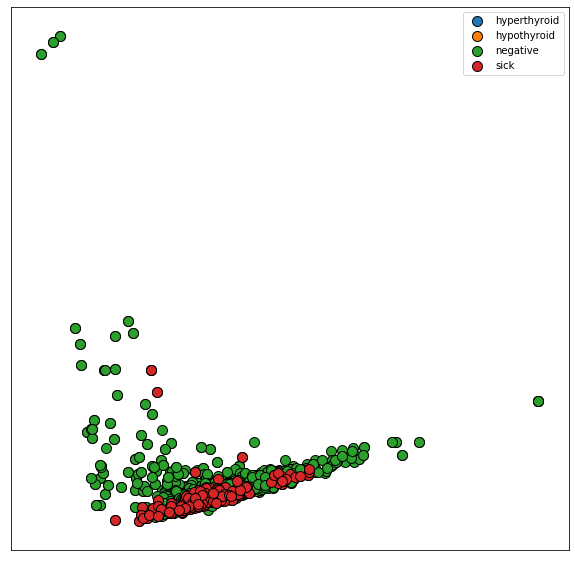

In [24]:
def plot_pca_data(X, y):    
    
    LE = LabelEncoder()
    y_encoded = LE.fit_transform(y)
    
    pca = PCA(n_components=2)
    pca.fit(X)
    pca_X = pca.transform(X)

    x_axis = pca_X[:,0]
    y_axis = pca_X[:,1]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    for label in np.unique(y):
        ax.scatter(pca_X[y==label, 0],
                   pca_X[y==label, 1], 
                   label=label,
                   s=100,
                   edgecolor='k')
        

    ax.legend()
    plt.xticks([])
    plt.yticks([])

plot_pca_data(X, y)



In [25]:
#Model Selection

In [26]:
def search_for_parameters(estimator, X_data, y_data, grid_parameters, scoring='accuracy', cv=3):
    
    classes = y_data.unique()
    
    # Execute Grid Search
    grid_clf = GridSearchCV(estimator=estimator, scoring=scoring,
                            param_grid=grid_parameters, iid=False,
                            cv=cv,n_jobs=-1)
    
    grid_clf.fit(X_data, y_data)

    print("The best parameters are: ", grid_clf.best_params_)

    return grid_clf.best_params_

In [27]:
svm_clf = SVC(class_weight='balanced')

svm_params_list = {'C':[1,2,4,8], 
                   'kernel':['poly', 'rbf', 'sigmoid'], 
                   'degree':[3,4,5], 
                   'gamma':['auto','scale']}

svm_parameters = search_for_parameters(estimator=svm_clf, 
                                X_data=X_train, 
                                y_data=y_train, cv=5,
                                grid_parameters=svm_params_list)

svm_clf.set_params(**svm_parameters)

svm_clf.fit(X_train, y_train)

The best parameters are:  {'C': 8, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}


SVC(C=8, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
def cross_validate(estimator, X_data, y_data, scoring='accuracy', cv=3, Z=2):
    
    classes = y_data.unique()
    
    # Execute Cross Validation
    scores = cross_val_score(estimator=estimator, X=X_data, y=y_data, cv=cv, scoring=scoring)

    print("Model Scoring Evaluation Results")
    print("The mean score and the confidence interval of the score estimate are:")
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * Z))

cross_validate(estimator=svm_clf, X_data=X_train, y_data=y_train, cv=5)

Model Scoring Evaluation Results
The mean score and the confidence interval of the score estimate are:
Accuracy: 0.69 (+/- 0.04)


In [29]:
#Predict on Test Set

In [30]:
y_true, y_pred = y_test, svm_clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("*"*50)
print()
print("\t\t\tClassification Report")
print()
print(classification_report(y_true, y_pred))

Accuracy: 0.7109181141439206
**************************************************

			Classification Report

              precision    recall  f1-score   support

hyperthyroid       0.21      0.53      0.30        19
 hypothyroid       0.24      0.56      0.34        55
    negative       0.94      0.73      0.82       689
        sick       0.28      0.60      0.38        43

    accuracy                           0.71       806
   macro avg       0.42      0.61      0.46       806
weighted avg       0.84      0.71      0.76       806



In [31]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
print(cm)

[[506  34  87  62]
 [  8  10   0   1]
 [ 20   0  31   4]
 [  5   3   9  26]]
